# Phishing Domain Classifier

## Import Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

## Importing the dataset
The dataset documentation states the following:
<br>a.  -1 Phishing
<br>b.  0 Suspicious
<br>c.  1 Legitimate

In [79]:
dataset = pd.read_csv('../data/raw/phishing_data.csv')
dataset.sample(5)

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
10263,1,-1,1,-1,1,1,0,1,-1,1,...,1,1,1,1,-1,-1,1,0,1,1
4277,1,-1,1,1,1,-1,1,1,1,1,...,1,1,1,1,-1,-1,1,0,1,1
10129,-1,-1,1,1,1,1,-1,1,1,1,...,1,1,1,1,-1,-1,1,1,1,1
1846,1,-1,1,1,1,-1,-1,-1,-1,1,...,1,1,-1,-1,0,-1,-1,0,1,-1
7753,1,-1,1,1,1,-1,1,1,-1,1,...,1,1,-1,1,0,1,1,0,1,1


In [80]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

There is no null features

In [81]:
dataset['Result'].value_counts()

Result
 1    6157
-1    4898
Name: count, dtype: int64

There is class imbalance, I will address it during hyperparameter tuning

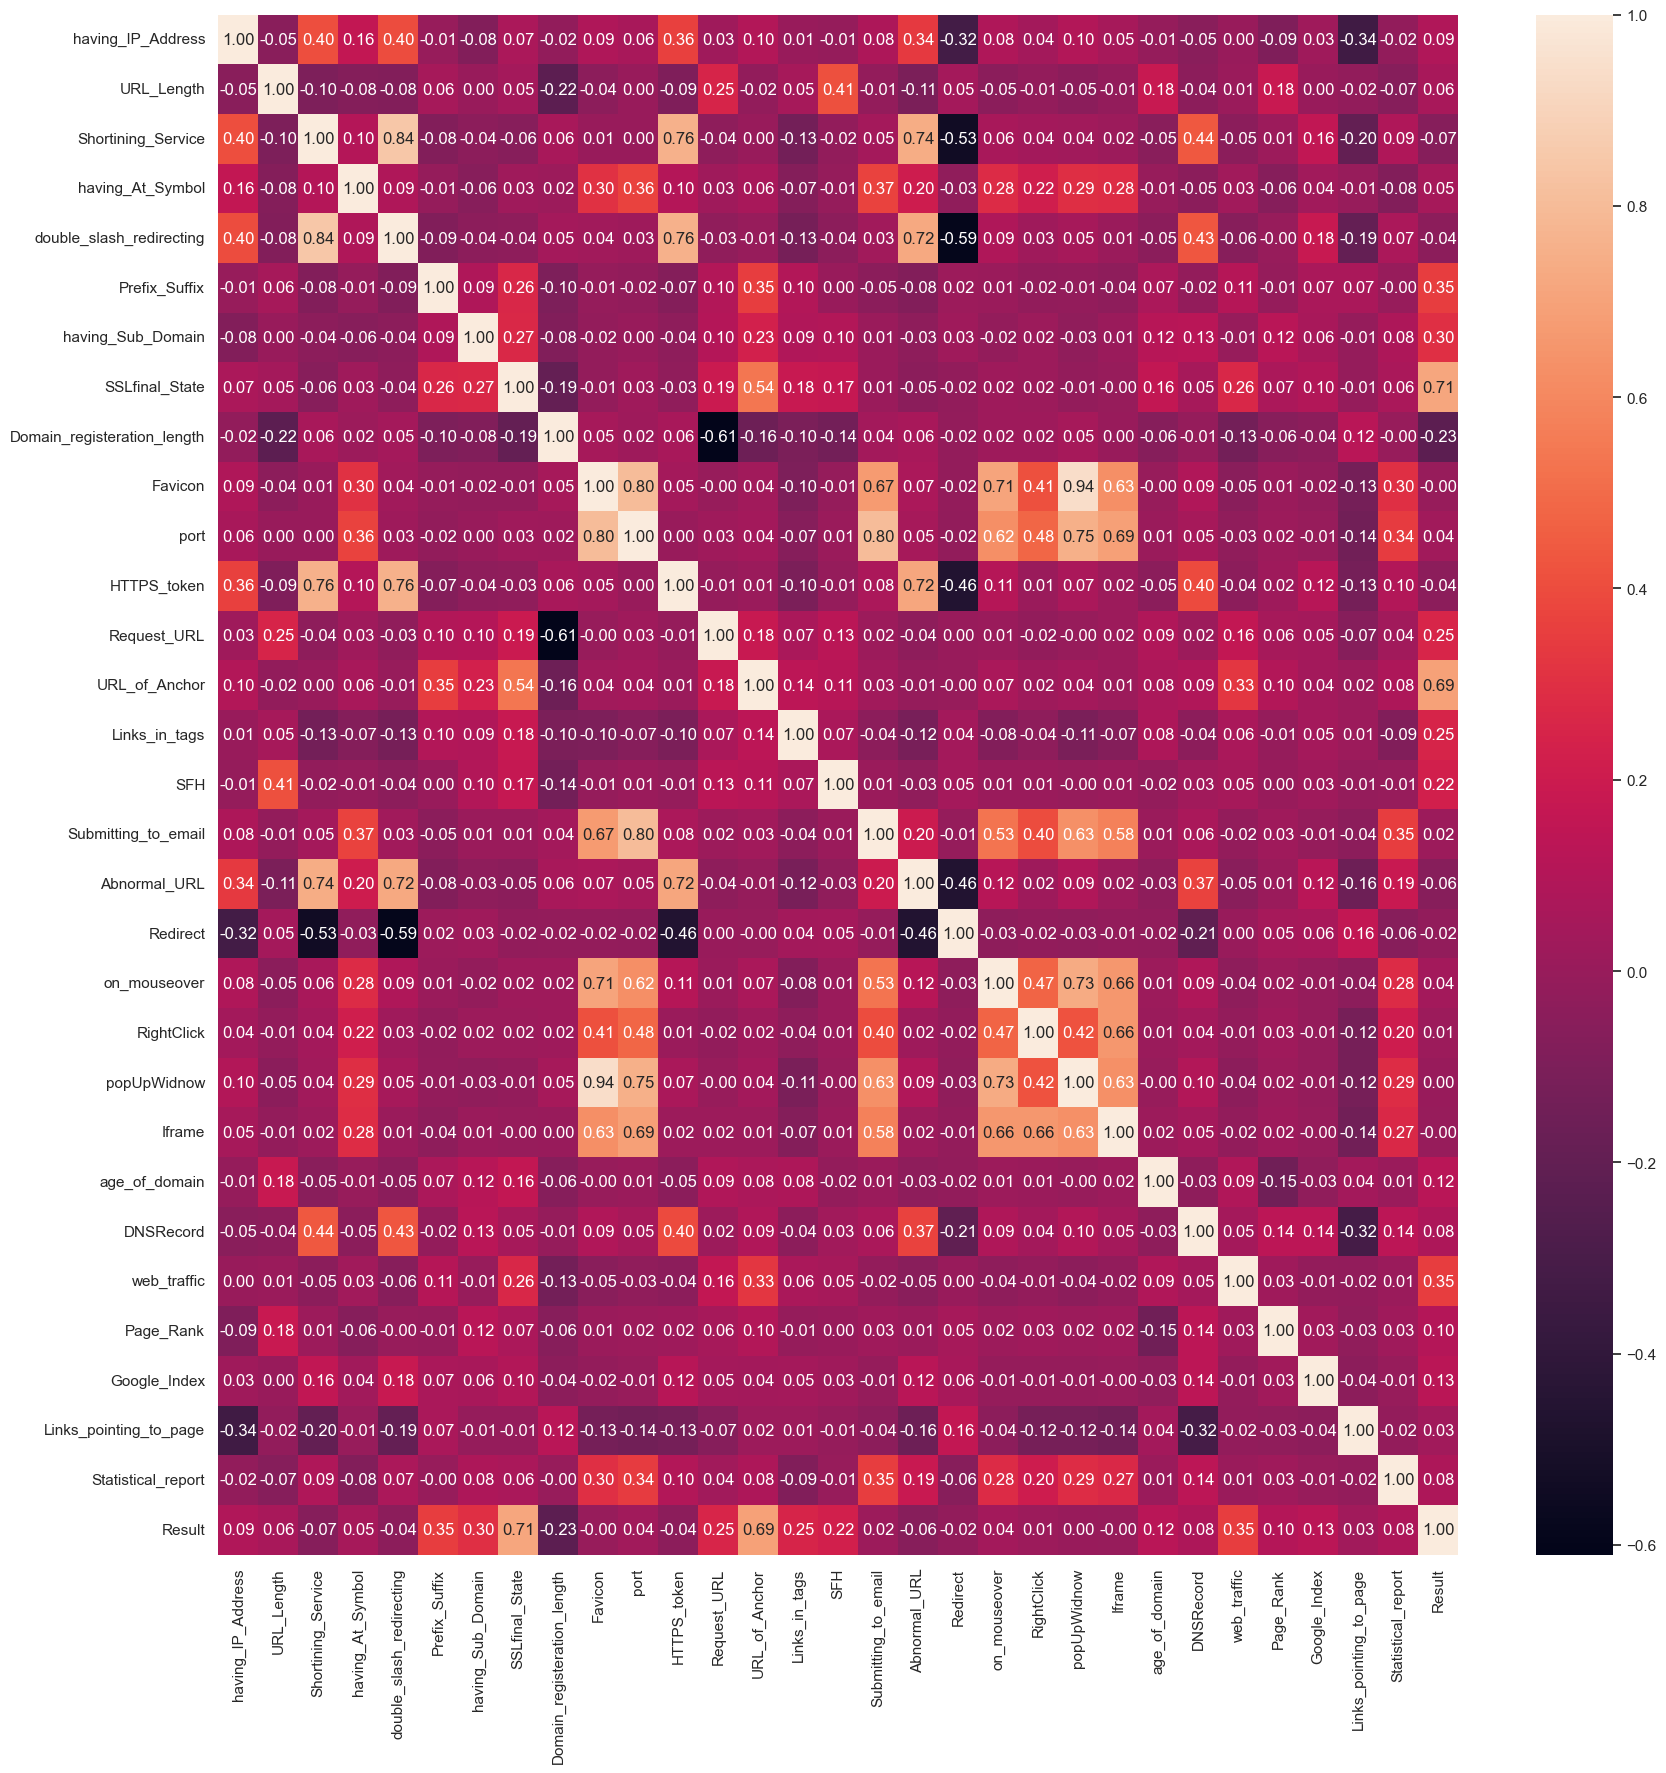

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(dataset.corr(), annot=True, fmt=".2f")
plt.savefig("../reports/figures/heatmap.png")
plt.show()

In [83]:
# Split the dataset between dependent and independent variable as an array
X = dataset.drop('Result', axis=1)
y = dataset['Result'].replace(-1,0)

In [85]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [86]:
# Initialize a dictionary to store Cramér's V values
cramers_v_values = {}

for column in X.columns:
    # Ensure the column is categorical; if not, convert it
    if X[column].dtype.name not in ['category', 'object']:
        X[column] = X[column].astype('category')
    
    # Calculate Cramér's V
    cramers_v_score = cramers_v(X[column], y)
    cramers_v_values[column] = cramers_v_score
    print(f"Cramér's V for {column}: {cramers_v_score:.4f}")

# Convert the dictionary to a DataFrame for easier plotting
cramers_v_df = pd.DataFrame.from_dict(cramers_v_values, orient='index', columns=["Cramér's V"])
cramers_v_df = cramers_v_df.sort_values(by="Cramér's V", ascending=False)

Cramér's V for having_IP_Address: 0.0935
Cramér's V for URL_Length: 0.0710
Cramér's V for Shortining_Service: 0.0670
Cramér's V for having_At_Symbol: 0.0518
Cramér's V for double_slash_redirecting: 0.0371
Cramér's V for Prefix_Suffix: 0.3482
Cramér's V for having_Sub_Domain: 0.3797
Cramér's V for SSLfinal_State: 0.7776
Cramér's V for Domain_registeration_length: 0.2254
Cramér's V for Favicon: 0.0000
Cramér's V for port: 0.0349
Cramér's V for HTTPS_token: 0.0384
Cramér's V for Request_URL: 0.2530
Cramér's V for URL_of_Anchor: 0.7346
Cramér's V for Links_in_tags: 0.2535
Cramér's V for SFH: 0.2211
Cramér's V for Submitting_to_email: 0.0153
Cramér's V for Abnormal_URL: 0.0595
Cramér's V for Redirect: 0.0174
Cramér's V for on_mouseover: 0.0405
Cramér's V for RightClick: 0.0076
Cramér's V for popUpWidnow: 0.0000
Cramér's V for Iframe: 0.0000
Cramér's V for age_of_domain: 0.1209
Cramér's V for DNSRecord: 0.0749
Cramér's V for web_traffic: 0.3933
Cramér's V for Page_Rank: 0.1040
Cramér's V for

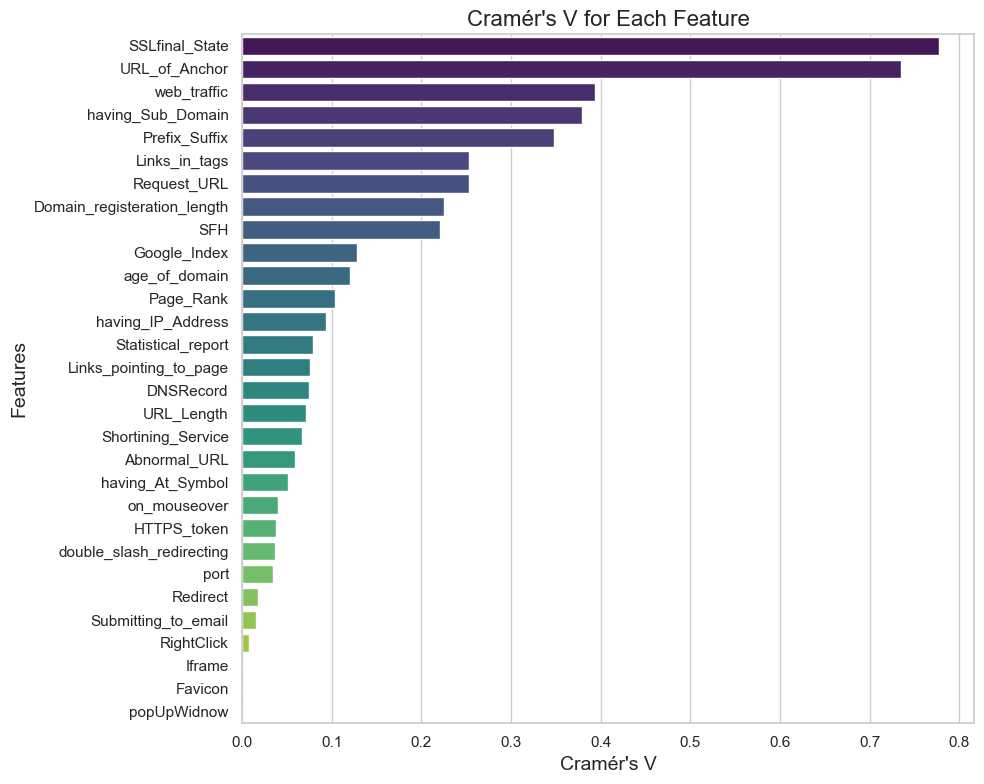

In [87]:
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))

sns.barplot(x="Cramér's V", y=cramers_v_df.index, data=cramers_v_df, palette="viridis")

plt.title("Cramér's V for Each Feature", fontsize=16)
plt.xlabel("Cramér's V", fontsize=14)
plt.ylabel("Features", fontsize=14)

plt.tight_layout()
plt.savefig("../reports/figures/creamersv.png")
plt.show()

It's safe to say that the top 2 variables a very strong relationship with the target variable

## Splitting the dataset into the Training set and Test set

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42, stratify=y)

## Lazy Classifier

In [92]:
# from lazypredict.Supervised import LazyClassifier

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# models.head()

100%|██████████| 31/31 [00:39<00:00,  1.28s/it]

[LightGBM] [Info] Number of positive: 5541, number of negative: 4408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 9949, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556940 -> initscore=0.228754
[LightGBM] [Info] Start training from score 0.228754


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.98,0.98,0.98,0.98,0.73
RandomForestClassifier,0.97,0.97,0.97,0.97,0.65
XGBClassifier,0.97,0.97,0.97,0.97,0.17
BaggingClassifier,0.97,0.97,0.97,0.97,0.18
LGBMClassifier,0.97,0.97,0.97,0.97,0.15


## Model


In [118]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = ExtraTreesClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

### Cross Validation Score

In [119]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf,X, y, cv=skf)

print(f"Cross-validated scores: {scores}")
print(f"Mean cross-validated score: {scores.mean()}")

Cross-validated scores: [0.97150611 0.97376753 0.97241067 0.97014925 0.96788783]
Mean cross-validated score: 0.9711442786069652


## Performance

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Recall (Sensitivity)
recall = recall_score(y_test, y_pred)

# F1-Score
f1 = f1_score(y_test, y_pred)

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Print all the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1-Score: 0.98
ROC-AUC Score: 0.98
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       980
           1       0.98      0.98      0.98      1231

    accuracy                           0.98      2211
   macro avg       0.98      0.98      0.98      2211
weighted avg       0.98      0.98      0.98      2211



### Confusion Matrix

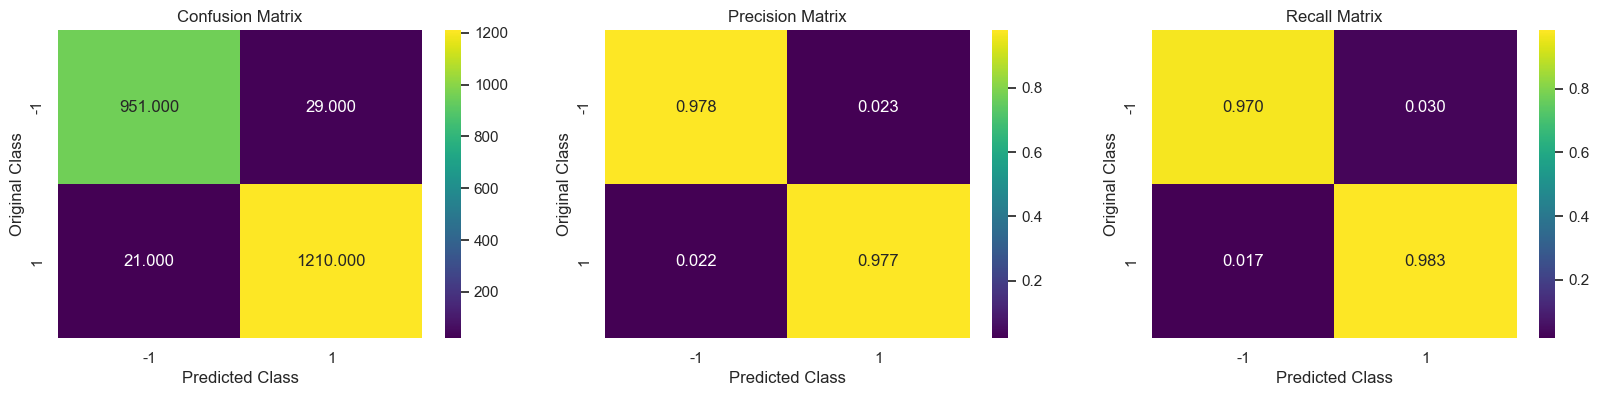

In [ ]:
def plot_confusion_matrix(test_Y, predict_y):
    C = confusion_matrix(test_Y, predict_y)
    A = (((C.T) / (C.sum(axis=1))).T)
    B = (C / C.sum(axis=0))
    plt.figure(figsize=(20, 4))
    labels = [-1, 1]
    cmap = sns.color_palette("viridis", as_cmap=True)
    
    # confusion matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion Matrix")
    
    # recision matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision Matrix")
    
    # recall matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall Matrix")
    
    plt.savefig("../reports/figures/confusion_matrix.png")
    plt.show()

plot_confusion_matrix(y_test, y_pred)